# 합병증 분류 예측 모델링(2차)

- Date : 2022/9/5 ~ 2022/9/28
- Data : full_data_220907 (Ver1.1).xlsx
- Process : Data load ->  EDA -> Data preprocessing & engineering -> Modeling
- Model(참고용) : 
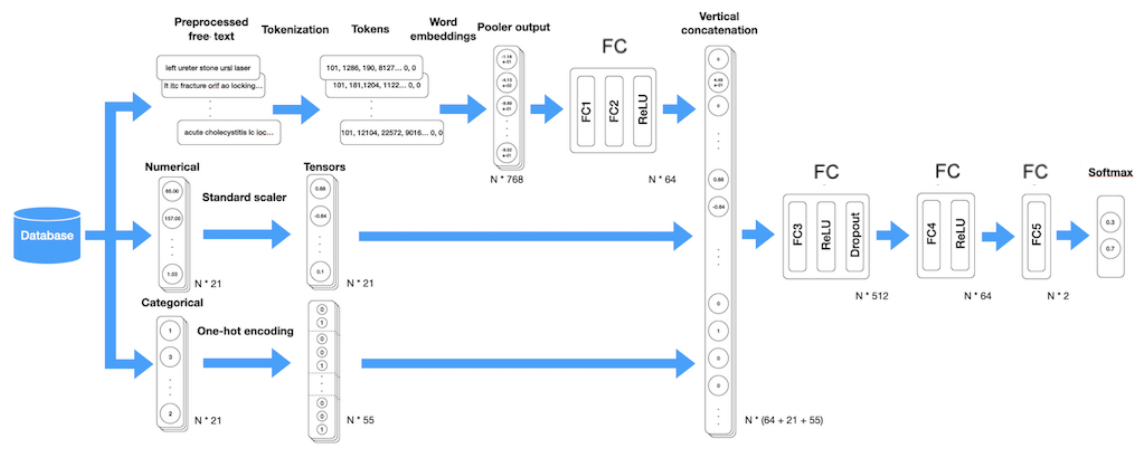
- Reference : 
  - [Predicting Postoperative Mortality With Deep Neural Networks
and Natural Language Processing: Model Development and
Validation](https://dmmj3ljielax6.cloudfront.net/upload/chat/cc1e7aea-bb3d-4127-a9e9-cf61504c8be6.pdf)
  - [국민건강영양조사를 활용한 대사증후군 유병 예측모형
개발을 위한 융복합 연구](https://koreascience.kr/article/JAKO201609562998521.pdf)
  - [Publicly Available Clinical BERT Embeddings](https://arxiv.org/pdf/1904.03323.pdf)

## 논문 정리(참고)  

### <진행 내용>

- 수치형 변수는 Standard scaling 진행
- 수치형 변수의 결측치는 중앙값 대체 진행(이상치 또한 중앙값 대체 진행)
- 범주형 변수는 더미화 진행 
- 범주형 변수의 결측치는 과반수 이상 범주로 대체 
- 텍스트 변수는 stopword 제거 등의 nlp 과정 진행
- 전처리된 텍스트는 Bert Tokenizer를 통해 토큰화 한 후 bio clinical bert를 통해 768차원의 벡터로 임베딩 진행 
- cross entropy loss function에서 class 불균형 보정을 위해 inverse-frequency class weighting 사용됨 
- batch size는 64, optimizer는 AdamW 사용, lr은 0.00002 사용 val loss 기준 early stopping 사용 
- 심각한 class 불균형으로 인해(1562/121,313), precision, recall, speicific, f1 score, AUPRC 등 사용 
- 최종 평가는 test set 1000번 bootstrap sample 후, metric별 95% 신뢰구간까지 구함
- 제안된 BERT-DNN 모델이 모든 metric에서 좋은 성능을 보이진 않음
- AUROC, AUPRC, F1-score, recall, specificity는 대부분 높음
- 도메인 관점에서 중요할 수 있는 Precision은 오히려 머신러닝 알고리즘이 높음(내 주관 판단)

### <한계점>
- 클래스의 불균형이 매우 심함
- 전자건강기록(EHR)을 사용하여 측정된 데이터에 오류가 많았음(결측치, 이상치 포함)
- 모든 기록은 하나의 대형 메디컬 센터에서 수집되었으므로 일반화 가능성에도 검토해볼 필요가 있음 

## Colab & Drive Setting

In [ ]:
# google drive 연동
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/MyDrive/숨고/윤현규님(합병증 예측)/2차 과제') # 해당 path는 환경에 맞게 변경해야 함

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Import Library

In [ ]:
!pip install transformers
!pip install missingno

import pandas as pd, numpy as np, random, re, pickle
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.calibration import calibration_curve
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, PrecisionRecallDisplay, brier_score_loss
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler 
from transformers import AutoTokenizer, AutoModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import missingno as msno
nltk.download('stopwords')
nltk.download('punkt')

# tensorflow/keras
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, BatchNormalization
from keras.layers.advanced_activations import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Load

In [ ]:
data = pd.read_excel("full_data_220907 (Ver1.1).xlsx")
data = data[[i for i in data.columns if i!='tb']]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185430 entries, 0 to 185429
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   caseid          185430 non-null  int64  
 1   first_outcome   185430 non-null  int64  
 2   second_outcome  185430 non-null  int64  
 3   yr              185430 non-null  int64  
 4   em              185430 non-null  int64  
 5   dm              185430 non-null  int64  
 6   htn             185430 non-null  int64  
 7   asa             172300 non-null  float64
 8   andur           184722 non-null  float64
 9   expd            185430 non-null  float64
 10  age             185430 non-null  float64
 11  sex             185430 non-null  int64  
 12  wt              183519 non-null  float64
 13  ht              183361 non-null  float64
 14  bm              180873 non-null  float64
 15  atype           185430 non-null  int64  
 16  hem             181630 non-null  float64
 17  wb        

In [ ]:
data

,caseid,first_outcome,second_outcome,yr,em,dm,htn,asa,andur,expd,...,ap,al,got,gpt,sod,pot,gl,dept,name,diagnosis
0,1,1,0,2004,1,0,0,NaN,290.0,3.0,...,46.2,2.3,19.0,22.0,126.0,3.7,95.0,GS,Explorative laparotomy,peritonitis
1,2,0,0,2004,1,0,0,NaN,160.0,3.0,...,31.1,4.3,24.0,25.0,135.0,4.7,128.0,GS,Explorative Laparotomy(Gyn),Mechanical Ileus
2,3,0,0,2004,1,0,1,NaN,60.0,1.5,...,38.5,4.0,16.0,19.0,143.0,4.4,121.0,OL,Rigid Bronchoscopic Excision of Tracheal or B...,lung cancer
3,4,0,0,2004,1,0,0,NaN,130.0,2.0,...,34.2,4.3,20.0,50.0,143.0,4.5,113.0,TS,Video-assisted thoracoscopic surgery(VATS),pneumothorax
4,5,0,0,2004,1,0,0,NaN,NaN,1.0,...,39.4,4.2,8.0,17.0,136.0,4.1,139.0,GS,Appendectomy,acute appendicitis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185425,186299,0,0,2022,0,0,0,2.0,460.0,3.0,...,33.9,4.4,16.0,19.0,141.0,4.1,NaN,GS,Living donor hepatectomy ( laparoscopic ),Liver donor
185426,186300,0,0,2022,0,1,1,2.0,200.0,3.0,...,41.5,4.2,21.0,31.0,140.0,4.5,NaN,GS,Laparoscopic segmentectomy of liver : S5 + Cho...,Intraductal papillary mucinous neoplasm of bil...
185427,186301,0,0,2022,0,0,1,2.0,190.0,3.0,...,30.6,4.7,18.0,24.0,138.0,4.3,252.0,GS,Total gastrectomy ( with modified lymph node d...,Advanced gastric cancer
185428,186302,0,0,2022,0,0,0,2.0,190.0,3.0,...,31.2,4.0,24.0,17.0,141.0,4.2,103.0,GS,Total gastrectomy ( with modified lymph node d...,Advanced gastric cancer


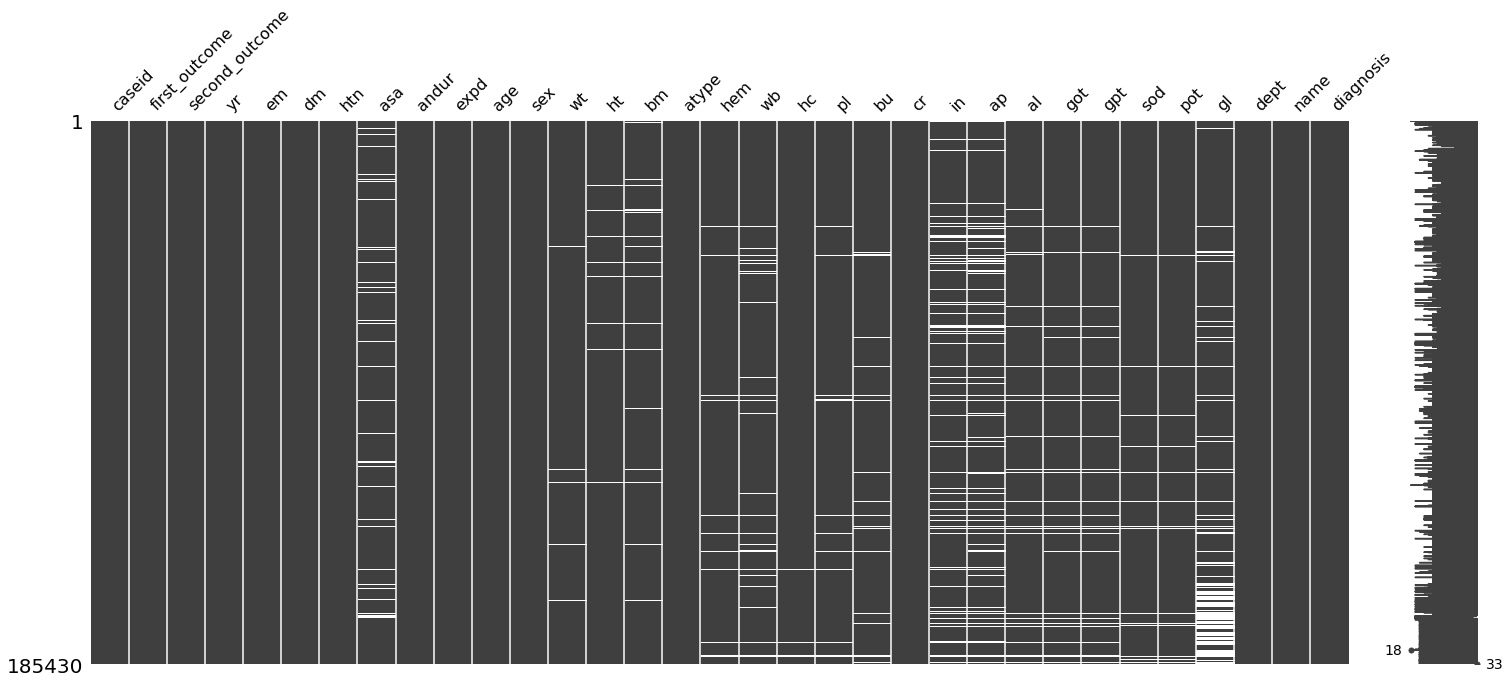

In [ ]:
# missing value visualization
msno.matrix(data)

## Fill NA

In [ ]:
# Fill NA with MICE
col = [i for i in data.columns if i not in ['caseid','dept','name','diagnosis']]

imp_algorithm = IterativeImputer(random_state=20220918)
imp_data = imp_algorithm.fit_transform(data[col])
imp_data = pd.DataFrame(imp_data, columns=col)
imp_data.loc[:,'asa'] = imp_data['asa'].round(1)
imp_data = pd.concat([imp_data, data[['caseid','dept','name','diagnosis']]],axis=1)

with open('./result/processed data/imputed_data.pickle', 'wb') as f:
    pickle.dump(imp_data, f)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [ ]:
with open('./result/processed data/imputed_data.pickle', 'rb') as f:
    imp_data = pickle.load(f)

In [ ]:
imp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185430 entries, 0 to 185429
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   first_outcome   185430 non-null  float64
 1   second_outcome  185430 non-null  float64
 2   yr              185430 non-null  float64
 3   em              185430 non-null  float64
 4   dm              185430 non-null  float64
 5   htn             185430 non-null  float64
 6   asa             185430 non-null  float64
 7   andur           185430 non-null  float64
 8   expd            185430 non-null  float64
 9   age             185430 non-null  float64
 10  sex             185430 non-null  float64
 11  wt              185430 non-null  float64
 12  ht              185430 non-null  float64
 13  bm              185430 non-null  float64
 14  atype           185430 non-null  float64
 15  hem             185430 non-null  float64
 16  wb              185430 non-null  float64
 17  hc        

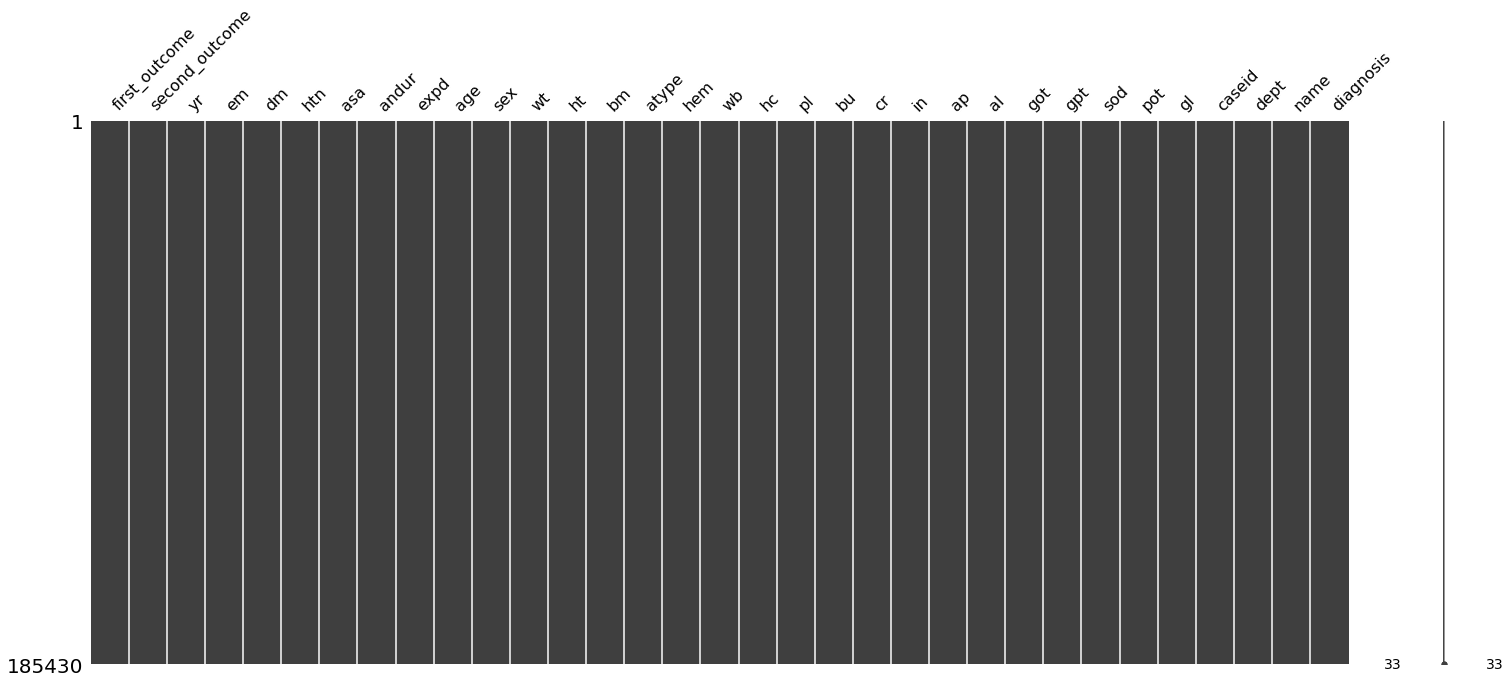

In [ ]:
# missing value visualization
msno.matrix(imp_data)

## Feature Engineering

In [ ]:
data_copied = imp_data.copy()

In [ ]:
# Numerical Features Engineering

# yr, hem, pot 제외
data_copied = data_copied.drop(['yr', 'hem', 'pot'], axis=1)

In [ ]:
# Categorical Features Engineering

# dept
data_copied['dept_separate'] = data_copied['dept'].apply(lambda x : x if (x=='TS') | (x=='UR') else 'Others')
data_copied = data_copied.drop(['dept'], axis=1)

# one-hot-encoding
def onehot(df, col):
    onehot = OneHotEncoder(sparse=False)
    onehot_data = onehot.fit_transform(df[col].values.reshape(-1,1))
    onehot_data = pd.DataFrame(onehot_data, columns=[col + "_" + i for i in onehot.categories_])
    df = pd.concat([df, onehot_data], axis=1)
    df = df.drop([col], axis=1)

    return df

data_copied = onehot(data_copied, "dept_separate")

In [ ]:
# 수술명/진단명 통한 파생변수 생성(환자수 기준 3시그마 수술/진단명 리스트 중 합병증률 20%이상인 리스트 추출하여 해당하는 수술/진단명 환자는 1, 아닌 경우 0
name_list = pd.read_csv("수술명.csv")
data_copied['name_selected'] = data_copied['name'].apply(lambda x:1 if x in name_list.loc[name_list['rate']>=0.2,"name"].values else 0)

diag_list = pd.read_csv("진단명.csv")
data_copied['diag_selected'] = data_copied['diagnosis'].apply(lambda x:1 if x in diag_list.loc[diag_list['rate']>=0.2,"diagnosis"].values else 0)

In [ ]:
# NLP

# name 변수와 diagnosis 변수 내 특수문자만 제거 
data_copied['name_rmv'] = data_copied['name'].str.replace(pat=r'[^A-Za-z0-9]', repl=r' ', regex=True)
data_copied['diagnosis_rmv'] = data_copied['diagnosis'].str.replace(pat=r'[^A-Za-z0-9]', repl=r' ', regex=True)

data_copied = data_copied.drop(['name', 'diagnosis'], axis=1)

## Sampling(Random under sampling) : 텍스트가 존재하므로

In [ ]:
# undersampling(sampling_strategy = minority_num / majority_num)
rus = RandomUnderSampler(sampling_strategy = 'majority', random_state=20220820)
X_res, y_res = rus.fit_resample(data_copied.drop(['second_outcome','first_outcome'],axis=1), data_copied['first_outcome'])

data_copied = pd.concat([X_res, pd.DataFrame(y_res)], axis=1).reset_index(drop=True)
data_copied.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


,em,dm,htn,asa,andur,expd,age,sex,wt,ht,...,gl,caseid,"(dept_separate_Others,)","(dept_separate_TS,)","(dept_separate_UR,)",name_selected,diag_selected,name_rmv,diagnosis_rmv,first_outcome
0,0.0,0.0,0.0,1.0,90.0,1.5,57.00,0.0,96.75,170.3,...,126.0,89654,1.0,0.0,0.0,0,0,A S labrum repair Lt,Anterior instability of shoulder,0.0
1,0.0,0.0,0.0,2.0,255.0,3.5,52.00,0.0,58.60,160.9,...,132.0,91862,1.0,0.0,0.0,0,0,Total revision THRA Lt osteonics ...,Loosening total hip arthroplasty,0.0
2,0.0,0.0,1.0,1.0,240.0,4.0,70.00,1.0,48.20,147.0,...,93.0,19924,1.0,0.0,0.0,0,0,Distal pancreatectomy,intraductal papillary mucinous tumor,0.0
3,0.0,0.0,0.0,1.0,145.0,2.5,69.41,1.0,63.30,162.9,...,105.0,124433,1.0,0.0,0.0,0,0,THRA total hip replacement arthroplasty le...,Degenerative arthritis hip,0.0
4,0.0,0.0,1.0,2.0,390.0,2.0,70.13,0.0,74.50,174.6,...,103.0,144632,1.0,0.0,0.0,0,0,OLIF oblique lumbar interbody fusion left ...,Herniated disc disease of lumbar spine,0.0
5,0.0,0.0,0.0,1.0,110.0,2.0,66.00,1.0,64.55,158.3,...,103.0,75470,1.0,0.0,0.0,0,0,Arthroscopic repair of rotator cuff shoulder ...,rotator cuff tear Other and unspecified,0.0
6,0.0,0.0,0.0,1.0,110.0,3.0,62.28,1.0,46.90,157.0,...,154.0,142117,0.0,1.0,0.0,0,0,Wedge resection of lung RLL VATS with me...,Solitary pulmonary nodule,0.0
7,0.0,0.0,0.0,1.0,350.0,6.0,39.00,0.0,73.75,169.1,...,128.0,72546,1.0,0.0,0.0,0,0,living donor hepatectomy,liver Donor,0.0
8,0.0,0.0,1.0,2.0,117.0,2.0,76.00,1.0,54.30,145.5,...,110.0,87872,0.0,1.0,0.0,0,0,VATS metastasectomy LUL double lumen,Rectal cancer,0.0
9,0.0,0.0,1.0,1.0,255.0,3.0,74.00,1.0,51.00,140.0,...,83.0,51264,1.0,0.0,0.0,0,0,Revision of total knee replacement arthroplast...,loosening total knee replacement arthroplasty,0.0


In [ ]:
data

,caseid,first_outcome,second_outcome,yr,em,dm,htn,asa,andur,expd,...,ap,al,got,gpt,sod,pot,gl,dept,name,diagnosis
0,1,1,0,2004,1,0,0,NaN,290.0,3.0,...,46.2,2.3,19.0,22.0,126.0,3.7,95.0,GS,Explorative laparotomy,peritonitis
1,2,0,0,2004,1,0,0,NaN,160.0,3.0,...,31.1,4.3,24.0,25.0,135.0,4.7,128.0,GS,Explorative Laparotomy(Gyn),Mechanical Ileus
2,3,0,0,2004,1,0,1,NaN,60.0,1.5,...,38.5,4.0,16.0,19.0,143.0,4.4,121.0,OL,Rigid Bronchoscopic Excision of Tracheal or B...,lung cancer
3,4,0,0,2004,1,0,0,NaN,130.0,2.0,...,34.2,4.3,20.0,50.0,143.0,4.5,113.0,TS,Video-assisted thoracoscopic surgery(VATS),pneumothorax
4,5,0,0,2004,1,0,0,NaN,NaN,1.0,...,39.4,4.2,8.0,17.0,136.0,4.1,139.0,GS,Appendectomy,acute appendicitis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185425,186299,0,0,2022,0,0,0,2.0,460.0,3.0,...,33.9,4.4,16.0,19.0,141.0,4.1,NaN,GS,Living donor hepatectomy ( laparoscopic ),Liver donor
185426,186300,0,0,2022,0,1,1,2.0,200.0,3.0,...,41.5,4.2,21.0,31.0,140.0,4.5,NaN,GS,Laparoscopic segmentectomy of liver : S5 + Cho...,Intraductal papillary mucinous neoplasm of bil...
185427,186301,0,0,2022,0,0,1,2.0,190.0,3.0,...,30.6,4.7,18.0,24.0,138.0,4.3,252.0,GS,Total gastrectomy ( with modified lymph node d...,Advanced gastric cancer
185428,186302,0,0,2022,0,0,0,2.0,190.0,3.0,...,31.2,4.0,24.0,17.0,141.0,4.2,103.0,GS,Total gastrectomy ( with modified lymph node d...,Advanced gastric cancer


## Embedding

In [ ]:
# Sentence embedding by 
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def embedding(name_data, diag_data):
    name_list_data = name_data.values.reshape(-1).tolist()
    diag_list_data = diag_data.values.reshape(-1).tolist()
    name_result = np.zeros((1,768))
    diag_result = np.zeros((1,768))
    for i in range(0,len(name_list_data),100):
        print(i)
        name_encoded_input = tokenizer(name_list_data[i:i+100], padding=True, return_tensors='pt') # tokenize 결과를 tensor로 반환(모든 문장의 시작에 위치하는 CLS 토큰과 문장의 끝에 들어가는 SEP 토큰에 대한 index 포함)
        name_model_output = model(**name_encoded_input) # last_hidden_state : (batchsize, sequence size, vector size) / pooler_output : (batchsize,vector size), pooler_output은 CLS토큰에 대한 벡터값
        name_result = np.concatenate((name_result,name_model_output.pooler_output.detach().numpy()), axis=0)
        del name_model_output

        diag_encoded_input = tokenizer(diag_list_data[i:i+100], padding=True, return_tensors='pt') # tokenize 결과를 tensor로 반환(모든 문장의 시작에 위치하는 CLS 토큰과 문장의 끝에 들어가는 SEP 토큰에 대한 index 포함)
        diag_model_output = model(**diag_encoded_input) # last_hidden_state : (batchsize, sequence size, vector size) / pooler_output : (batchsize,vector size), pooler_output은 CLS토큰에 대한 벡터값
        diag_result = np.concatenate((diag_result,diag_model_output.pooler_output.detach().numpy()), axis=0)
        del diag_model_output

    return (name_result[1:,:], diag_result[1:,:])

name_embedding, diag_embedding = embedding(data_copied['name_rmv'], data_copied['diagnosis_rmv'])

data_copied = data_copied.drop(['name_rmv', 'diagnosis_rmv'], axis=1) 

In [ ]:
# save
data_processed = data_copied.copy()
data_processed.to_csv('./result/processed data/data_processed.csv', index=False)

with open('./result/embedding data/name_embedding.pickle', 'wb') as f:
    pickle.dump(name_embedding, f)

with open('./result/embedding data/diag_embedding.pickle', 'wb') as f:
    pickle.dump(diag_embedding, f)

## Data loading for training


In [ ]:
data_processed = pd.read_csv('./result/processed data/data_processed.csv')

with open('./result/embedding data/name_embedding.pickle', 'rb') as f:
    name_embedding = pickle.load(f)

with open('./result/embedding data/diag_embedding.pickle', 'rb') as f:
    diag_embedding = pickle.load(f)

data_total = pd.concat([data_processed, pd.DataFrame(name_embedding), pd.DataFrame(diag_embedding)], axis=1)

## Modeling

In [ ]:
# train/validation/test split
x_train, x_test, y_train, y_test = train_test_split(data_total.drop(['first_outcome'], axis=1), data_total['first_outcome'], test_size=0.2, random_state=20220822, stratify=data_total['first_outcome'])
x_train_val, x_val, y_train_val, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=20220822, stratify=y_train)

train_id = x_train[['caseid']]
x_train_mlp = x_train_val[[i for i in x_train_val.iloc[:,:30].columns if i not in ['caseid', 'name_rmv', 'diagnosis_rmv']]]
x_train_name_emb = x_train_val.iloc[:,30:798]
x_train_diag_emb = x_train_val.iloc[:,798:]

x_val_mlp = x_val[[i for i in x_val.iloc[:,:30].columns if i not in ['caseid', 'name_rmv', 'diagnosis_rmv']]]
x_val_name_emb = x_val.iloc[:,30:798]
x_val_diag_emb = x_val.iloc[:,798:]

test_id = x_test[['caseid']]
x_test_mlp = x_test[[i for i in x_test.iloc[:,:30].columns if i not in ['caseid', 'name_rmv', 'diagnosis_rmv']]]
x_test_name_emb = x_test.iloc[:,30:798]
x_test_diag_emb = x_test.iloc[:,798:]

In [ ]:
# feature scaling for DL
col = ['asa','age','wt','andur','expd','ht','bm','wb','hc','pl','bu','cr','in','ap','al','got','gpt','sod','gl']
mm = MinMaxScaler()
mm_train_data = mm.fit_transform(x_train_mlp[col])
mm_train_data = pd.DataFrame(mm_train_data, columns = col,index=x_train_mlp.index)
x_train_mlp[col] = mm_train_data

mm_val_data = mm.transform(x_val_mlp[col])
mm_val_data = pd.DataFrame(mm_val_data, columns = col,index=x_val_mlp.index)
x_val_mlp[col] = mm_val_data

mm_test_data = mm.transform(x_test_mlp[col])
mm_test_data = pd.DataFrame(mm_test_data, columns = col,index=x_test_mlp.index)
x_test_mlp[col] = mm_test_data

# feature scaling for ML
ml_train_y = y_train_val.copy()
ml_test_y = y_test.copy()
ml_train = x_train_val.copy()
ml_test = x_test.copy()
ml_train.columns = ml_train.columns[:30].tolist() + list(range(768*2))
ml_test.columns = ml_test.columns[:30].tolist() + list(range(768*2))

ml_mm = MinMaxScaler()
ml_mm_train_data = ml_mm.fit_transform(ml_train[ml_train.columns[30:]])
ml_mm_train_data = pd.DataFrame(ml_mm_train_data, columns = ml_train.columns[30:],index=ml_train.index)
ml_train[ml_train.columns[30:]] = ml_mm_train_data
ml_train = ml_train.drop(['caseid'],axis=1)

ml_mm_test_data = ml_mm.transform(ml_test[ml_test.columns[30:]])
ml_mm_test_data = pd.DataFrame(ml_mm_test_data, columns = ml_test.columns[30:],index=ml_test.index)
ml_test[ml_test.columns[30:]] = ml_mm_test_data
ml_test = ml_test.drop(['caseid'],axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

### Deep learning model

In [ ]:
# model architecture

# parameters 
emb_input_size = len(x_train_name_emb.columns) # 768
mlp_input_size = len(x_train_mlp.columns)
batch_size = 64
lr = 0.001
epochs = 1000

# name process
name_input = Input(shape=emb_input_size)
name_model = Dense(256, kernel_initializer='he_normal')(name_input)
name_model = BatchNormalization()(name_model)
name_model = ReLU()(name_model)
name_model = Dropout(0.5)(name_model)
name_model = Dense(128, kernel_initializer='he_normal')(name_model)
name_model = BatchNormalization()(name_model)
name_model = ReLU()(name_model)
name_model = Dropout(0.5)(name_model)
name_model = Dense(16, kernel_initializer='he_normal')(name_model)
name_model = BatchNormalization()(name_model)
name_model = ReLU()(name_model)
name_model = Dropout(0.5)(name_model)

# diag. process
diag_input = Input(shape=emb_input_size)
diag_model = Dense(256, kernel_initializer='he_normal')(diag_input)
diag_model = BatchNormalization()(diag_model)
diag_model = ReLU()(diag_model)
diag_model = Dropout(0.5)(diag_model)
diag_model = Dense(128, kernel_initializer='he_normal')(diag_model)
diag_model = BatchNormalization()(diag_model)
diag_model = ReLU()(diag_model)
diag_model = Dropout(0.5)(diag_model)
diag_model = Dense(16, kernel_initializer='he_normal')(diag_model)
diag_model = BatchNormalization()(diag_model)
diag_model = ReLU()(diag_model)
diag_model = Dropout(0.5)(diag_model)

# mlp process
mlp_input = Input(shape=mlp_input_size)

# concatenate
dl_model = concatenate([name_model, diag_model, mlp_input])

# Dense layer
dl_model = Dense(512,kernel_initializer='he_normal')(dl_model)
dl_model = BatchNormalization()(dl_model)
dl_model = ReLU()(dl_model)
dl_model = Dropout(0.5)(dl_model)
dl_model = Dense(256,kernel_initializer='he_normal')(dl_model)
dl_model = BatchNormalization()(dl_model)
dl_model = ReLU()(dl_model)
dl_model = Dropout(0.5)(dl_model)
dl_model = Dense(64,kernel_initializer='he_normal')(dl_model)
dl_model = BatchNormalization()(dl_model)
dl_model = ReLU()(dl_model)

# output layer
output = Dense(1, activation='sigmoid')(dl_model) # sigmoid를 통한 확률 계산

# final model
dl_model = Model(inputs=[name_input, diag_input, mlp_input], outputs=[output])


# optimizer
optimizer = optimizers.Adam(learning_rate=lr)

# model의 loss function, 사용할 optimizer, metirc 정의
dl_model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=[AUC()]) 

dl_model.summary() # 모델 전체 아키텍처 출력

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          196864      ['input_1[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 256)          196864      ['input_2[0][0]']                
                                                                                              

In [ ]:
# 학습 중 최상의 모델을 저장할 경로
best_weights_file="./result/model/weights.best.hdf5"

# 학습 중 validation acc 기준 최상의 모델을 저장하도록 checkpoint 설정
checkpoint = ModelCheckpoint(best_weights_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# model 학습 설정 및 학습 진행
history = dl_model.fit([x_train_name_emb, x_train_diag_emb, x_train_mlp], y_train_val,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[checkpoint, es],
                    verbose=1,
                    validation_data=([x_val_name_emb,x_val_diag_emb,x_val_mlp],y_val))

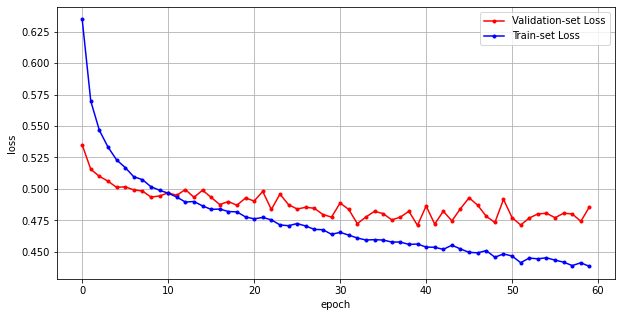

In [ ]:
# loss 그래프 출력
y_vloss = history.history['val_loss'] # 학습 중 validation loss 저장
y_loss = history.history['loss'] # 학습 중 train loss 저장
x_len = np.arange(len(y_loss)) # 전체 epoch 길이 저장

plt.figure(figsize=(10,5))
# validation loss에 대한 그래프 출력
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
# train loss에 대한 그래프 출력
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
# 저장된 deeplearning model load
best_weights_file="./result/model/weights.best.hdf5"
dl_model.load_weights(best_weights_file)

### RandomForest model

In [ ]:
rf_model = RandomForestClassifier(random_state=20220916)
param_grid = { 
    'n_estimators': [50,100,300,500,1000]
}

rf_grid = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv= 5, n_jobs=-1)
rf_grid.fit(ml_train, ml_train_y)

rf_model = RandomForestClassifier(n_estimators=rf_grid.best_params_['n_estimators'], random_state=20220916, n_jobs=-1)
rf_model.fit(ml_train, ml_train_y)

with open('./result/model/rf_model_embedding.pickle', 'wb') as f:
    pickle.dump(rf_model, f)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=20220916),
             n_jobs=-1, param_grid={'n_estimators': [50, 100, 300, 500, 1000]})

In [ ]:
# without embedding data

rf_model_no_emb = RandomForestClassifier(random_state=20220916, n_jobs=-1)
param_grid = { 
    'n_estimators': [50,100,300,500,1000]
}

rf_grid_no_emb = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv= 5, n_jobs=-1)
rf_grid_no_emb.fit(ml_train.iloc[:,:29], ml_train_y)

rf_model_no_emb = RandomForestClassifier(n_estimators=rf_grid_no_emb.best_params_['n_estimators'], random_state=20220916, n_jobs=-1)
rf_model_no_emb.fit(ml_train.iloc[:,:29], ml_train_y)

with open('./result/model/rf_model_no_embedding.pickle', 'wb') as f:
    pickle.dump(rf_model_no_emb, f)

In [ ]:
# 저장된 rf model load
with open('./result/model/rf_model_embedding.pickle', 'rb') as f:
    rf_model_emb = pickle.load(f)

with open('./result/model/rf_model_no_embedding.pickle', 'rb') as f:
    rf_model_no_emb = pickle.load(f)

### LightGBM model

In [ ]:
# with embedding data
lgbm_model = lgb.LGBMClassifier(random_state=20220916,n_jobs=-1)
param_grid = {'learning_rate':[0.05,0.1,0.2]}

lgbm_grid = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv= 5, n_jobs=-1)
lgbm_grid.fit(ml_train, ml_train_y)

lgbm_model = lgb.LGBMClassifier(learning_rate=lgbm_grid.best_params_['learning_rate'], random_state=20220916, n_jobs=-1)
lgbm_model.fit(ml_train, ml_train_y)

with open('./result/model/lgbm_model_embedding.pickle', 'wb') as f:
    pickle.dump(lgbm_model, f)

In [ ]:
# without embedding data

lgbm_model_no_emb = lgb.LGBMClassifier(random_state=20220916, n_jobs=-1)
param_grid = {'learning_rate':[0.05,0.1,0.2]}

lgbm_grid_no_emb = GridSearchCV(estimator=lgbm_model_no_emb, param_grid=param_grid, cv= 5, n_jobs=-1)
lgbm_grid_no_emb.fit(ml_train.iloc[:,:29], ml_train_y)

lgbm_model_no_emb = lgb.LGBMClassifier(learning_rate=lgbm_grid_no_emb.best_params_['learning_rate'], random_state=20220916, n_jobs=-1)
lgbm_model_no_emb.fit(ml_train.iloc[:,:29], ml_train_y)

with open('./result/model/lgbm_model_no_embedding.pickle', 'wb') as f:
    pickle.dump(lgbm_model_no_emb, f)

In [ ]:
# 저장된 lgmb model load
with open('./result/model/lgbm_model_embedding.pickle', 'rb') as f:
    lgbm_model_emb = pickle.load(f)

with open('./result/model/lgbm_model_no_embedding.pickle', 'rb') as f:
    lgbm_model_no_emb = pickle.load(f)

### XGBoost model

In [ ]:
# with embedding data
xgb_model = XGBClassifier(random_state=20220916, n_jobs=-1)
param_grid = {'n_estimators' : [100,300,500],'learning_rate' : [0.01,0.1]}

xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv= 5, n_jobs=-1)
xgb_grid.fit(ml_train, ml_train_y)

xgb_model = XGBClassifier(n_estimators=xgb_grid.best_params_['n_estimators'], learning_rate=xgb_grid.best_params_['learning_rate'], random_state=20220916, n_jobs=-1)
xgb_model.fit(ml_train, ml_train_y)

with open('./result/model/xgb_model_embedding.pickle', 'wb') as f:
    pickle.dump(xgb_model, f)

In [ ]:
# without embedding data

xgb_model_no_emb = XGBClassifier(random_state=20220916, n_jobs=-1)
param_grid = {'n_estimators' : [100,300,500],'learning_rate' : [0.01,0.1]}

xgb_grid_no_emb = GridSearchCV(estimator=xgb_model_no_emb, param_grid=param_grid, cv= 5, n_jobs=-1)
xgb_grid_no_emb.fit(ml_train.iloc[:,:29], ml_train_y)

xgb_model_no_emb = XGBClassifier(n_estimators=xgb_grid_no_emb.best_params_['n_estimators'], learning_rate=xgb_grid_no_emb.best_params_['learning_rate'], random_state=20220916, n_jobs=-1)
xgb_model_no_emb.fit(ml_train.iloc[:,:29], ml_train_y)

with open('./result/model/xgb_model_no_embedding.pickle', 'wb') as f:
    pickle.dump(xgb_model_no_emb, f)

In [ ]:
# 저장된 xgboost model load
with open('./result/model/xgb_model_embedding.pickle', 'rb') as f:
    xgb_model_emb = pickle.load(f)

with open('./result/model/xgb_model_no_embedding.pickle', 'rb') as f:
    xgb_model_no_emb = pickle.load(f)

## Evaluation

### deep learning model

In [ ]:
 # Metrics for confusion matrix
y_dl_pred = pd.DataFrame(dl_model.predict([x_test_name_emb, x_test_diag_emb, x_test_mlp]),columns=['predict_first_outcome'])
y_dl_pred[y_dl_pred['predict_first_outcome']>=0.5] = 1
y_dl_pred[y_dl_pred['predict_first_outcome']<0.5] = 0
target_names = ['0','1']
print(classification_report(y_test, y_dl_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80      2536
           1       0.80      0.78      0.79      2536

    accuracy                           0.79      5072
   macro avg       0.79      0.79      0.79      5072
weighted avg       0.79      0.79      0.79      5072



In [ ]:
# brier score loss(0~1 사이 범위를 가지며 0에 가까울수록 완벽한 분류모델
print("Brier score : ", brier_score_loss(y_test, dl_model.predict([x_test_name_emb, x_test_diag_emb, x_test_mlp])))

Brier score :  0.14447099195800314


AUROC :  0.79


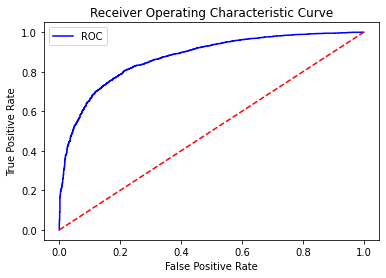

In [ ]:
# auroc
dl_auroc_score = roc_auc_score(y_test, y_dl_pred, average=None)
print("AUROC : ", round(dl_auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC(Receiver Operating Characteristic Curve)')
    plt.legend()
    plt.show()

prob = dl_model.predict([x_test_name_emb, x_test_diag_emb, x_test_mlp])
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)

AUPRC :  0.88


Text(0.5, 1.0, 'PRC(Precision Recall Curve)')

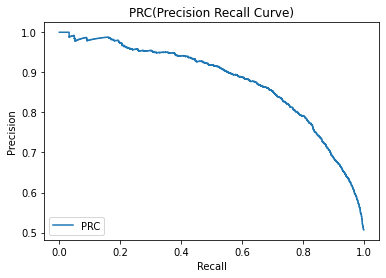

In [ ]:
# auprc
dl_auprc_score = average_precision_score(y_test, dl_model.predict([x_test_name_emb, x_test_diag_emb, x_test_mlp]), average=None)
print("AUPRC : ", round(dl_auprc_score,2))

# precision recall curve graph
_, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = precision_recall_curve(y_test, dl_model.predict([x_test_name_emb, x_test_diag_emb, x_test_mlp]))
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax, name='PRC')
ax.set_title('PRC(Precision Recall Curve)')

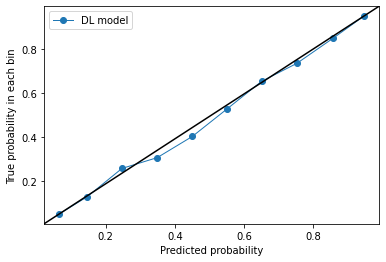

In [ ]:
# calibration curve
cal_y, cal_x = calibration_curve(y_test, dl_model.predict([x_test_name_emb, x_test_diag_emb, x_test_mlp]), n_bins=10)

_, ax = plt.subplots(figsize=(6, 4))
plt.plot(cal_x,cal_y,marker='o',linewidth=1,label='DL model')
line = mlines.Line2D([0,1], [0,1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability in each bin")
plt.legend()
plt.show()

### randomforest model(with embedding)

In [ ]:
 # Metrics for confusion matrix
y_rf_pred = pd.DataFrame(rf_model_emb.predict(ml_test), columns=['predict_first_outcome'])
y_rf_pred[y_rf_pred['predict_first_outcome']>=0.5] = 1
y_rf_pred[y_rf_pred['predict_first_outcome']<0.5] = 0
target_names = ['0','1']
print(classification_report(ml_test_y, y_rf_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


              precision    recall  f1-score   support

           0       0.73      0.83      0.78      2536
           1       0.81      0.70      0.75      2536

    accuracy                           0.77      5072
   macro avg       0.77      0.77      0.76      5072
weighted avg       0.77      0.77      0.76      5072



In [ ]:
# brier score loss(0~1 사이 범위를 가지며 0에 가까울수록 완벽한 분류모델
print("Brier score : ", brier_score_loss(y_test, rf_model_emb.predict_proba(ml_test)[:,1]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Brier score :  0.16115762574483


AUROC :  0.77


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


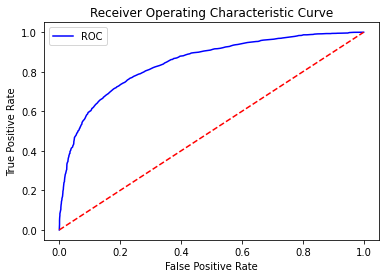

In [ ]:
# auroc
rf_auroc_score = roc_auc_score(ml_test_y, y_rf_pred, average=None)
print("AUROC : ", round(rf_auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = rf_model_emb.predict_proba(ml_test)[:,1]
fper, tper, thresholds = roc_curve(ml_test_y, prob)
plot_roc_curve(fper, tper)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


AUPRC :  0.85


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'PRC(Precision Recall Curve)')

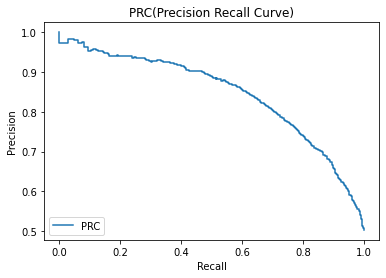

In [ ]:
# auprc
rf_auprc_score = average_precision_score(y_test,  rf_model_emb.predict_proba(ml_test)[:,1], average=None)
print("AUPRC : ", round(rf_auprc_score,2))

# precision recall curve graph
_, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = precision_recall_curve(y_test,  rf_model_emb.predict_proba(ml_test)[:,1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax, name='PRC')
ax.set_title('PRC(Precision Recall Curve)')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


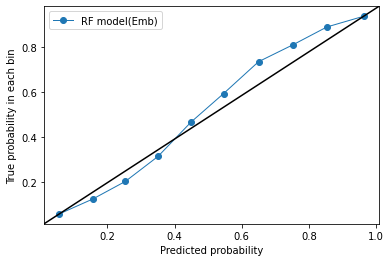

In [ ]:
# calibration curve
cal_y, cal_x = calibration_curve(y_test, rf_model_emb.predict_proba(ml_test)[:,1], n_bins=10)

_, ax = plt.subplots(figsize=(6, 4))
plt.plot(cal_x,cal_y,marker='o',linewidth=1,label='RF model(Emb)')
line = mlines.Line2D([0,1], [0,1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability in each bin")
plt.legend()
plt.show()

### randomforest model(without embedding)

In [ ]:
 # Metrics for confusion matrix
y_rf_noemb_pred = pd.DataFrame(rf_model_no_emb.predict(ml_test.iloc[:,:29]), columns=['predict_first_outcome'])
y_rf_noemb_pred[y_rf_noemb_pred['predict_first_outcome']>=0.5] = 1
y_rf_noemb_pred[y_rf_noemb_pred['predict_first_outcome']<0.5] = 0
target_names = ['0','1']
print(classification_report(ml_test_y, y_rf_noemb_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      2536
           1       0.78      0.76      0.77      2536

    accuracy                           0.78      5072
   macro avg       0.78      0.78      0.78      5072
weighted avg       0.78      0.78      0.78      5072



In [ ]:
# brier score loss(0~1 사이 범위를 가지며 0에 가까울수록 완벽한 분류모델
print("Brier score : ", brier_score_loss(y_test, rf_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1]))

Brier score :  0.15451933929197337


AUROC :  0.78


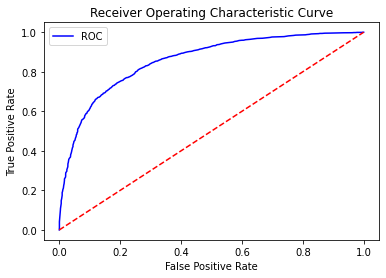

In [ ]:
# auroc
rf_noemb_auroc_score = roc_auc_score(ml_test_y, y_rf_noemb_pred, average=None)
print("AUROC : ", round(rf_noemb_auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = rf_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1]
fper, tper, thresholds = roc_curve(ml_test_y, prob)
plot_roc_curve(fper, tper)

AUPRC :  0.85


Text(0.5, 1.0, 'PRC(Precision Recall Curve)')

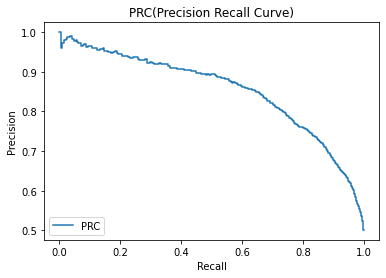

In [ ]:
# auprc
rf_noemb_auprc_score = average_precision_score(y_test, rf_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1], average=None)
print("AUPRC : ", round(rf_noemb_auprc_score,2))

# precision recall curve graph
_, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = precision_recall_curve(y_test, rf_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax, name='PRC')
ax.set_title('PRC(Precision Recall Curve)')

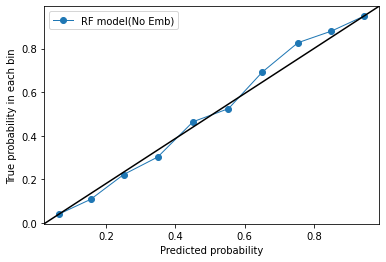

In [ ]:
# calibration curve
cal_y, cal_x = calibration_curve(y_test, rf_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1], n_bins=10)

_, ax = plt.subplots(figsize=(6, 4))
plt.plot(cal_x,cal_y,marker='o',linewidth=1,label='RF model(No Emb)')
line = mlines.Line2D([0,1], [0,1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability in each bin")
plt.legend()
plt.show()

### Light GBM model(with embedding)

In [ ]:
 # Metrics for confusion matrix
y_lgbm_pred = pd.DataFrame(lgbm_model_emb.predict(ml_test), columns=['predict_first_outcome'])
y_lgbm_pred[y_lgbm_pred['predict_first_outcome']>=0.5] = 1
y_lgbm_pred[y_lgbm_pred['predict_first_outcome']<0.5] = 0
target_names = ['0','1']
print(classification_report(ml_test_y, y_lgbm_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      2536
           1       0.81      0.78      0.80      2536

    accuracy                           0.80      5072
   macro avg       0.80      0.80      0.80      5072
weighted avg       0.80      0.80      0.80      5072



In [ ]:
# brier score loss(0~1 사이 범위를 가지며 0에 가까울수록 완벽한 분류모델
print("Brier score : ", brier_score_loss(y_test, lgbm_model_emb.predict_proba(ml_test)[:,1]))

Brier score :  0.1404673214948997


AUROC :  0.8


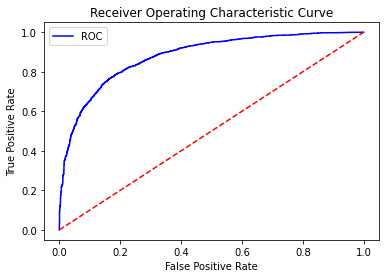

In [ ]:
# auroc
lgbm_auroc_score = roc_auc_score(ml_test_y, y_lgbm_pred, average=None)
print("AUROC : ", round(lgbm_auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = lgbm_model_emb.predict_proba(ml_test)[:,1]
fper, tper, thresholds = roc_curve(ml_test_y, prob)
plot_roc_curve(fper, tper)

AUPRC :  0.88


Text(0.5, 1.0, 'PRC(Precision Recall Curve)')

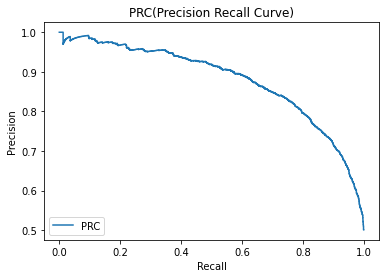

In [ ]:
# auprc
lgbm_auprc_score = average_precision_score(y_test, lgbm_model_emb.predict_proba(ml_test)[:,1], average=None)
print("AUPRC : ", round(lgbm_auprc_score,2))

# precision recall curve graph
_, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = precision_recall_curve(y_test, lgbm_model_emb.predict_proba(ml_test)[:,1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax, name='PRC')
ax.set_title('PRC(Precision Recall Curve)')

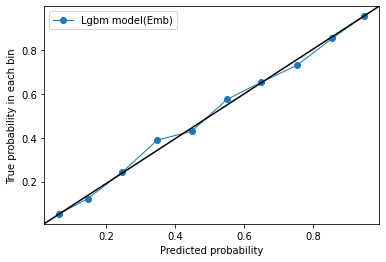

In [ ]:
# calibration curve
cal_y, cal_x = calibration_curve(y_test, lgbm_model_emb.predict_proba(ml_test)[:,1], n_bins=10)

_, ax = plt.subplots(figsize=(6, 4))
plt.plot(cal_x,cal_y,marker='o',linewidth=1,label='Lgbm model(Emb)')
line = mlines.Line2D([0,1], [0,1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability in each bin")
plt.legend()
plt.show()

### Light GBM model(without embedding)

In [ ]:
 # Metrics for confusion matrix
y_lgbm_noemb_pred = pd.DataFrame(lgbm_model_no_emb.predict(ml_test.iloc[:,:29]), columns=['predict_first_outcome'])
y_lgbm_noemb_pred[y_lgbm_noemb_pred['predict_first_outcome']>=0.5] = 1
y_lgbm_noemb_pred[y_lgbm_noemb_pred['predict_first_outcome']<0.5] = 0
target_names = ['0','1']
print(classification_report(ml_test_y, y_lgbm_noemb_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.77      0.78      0.78      2536
           1       0.78      0.77      0.77      2536

    accuracy                           0.77      5072
   macro avg       0.77      0.77      0.77      5072
weighted avg       0.77      0.77      0.77      5072



In [ ]:
# brier score loss(0~1 사이 범위를 가지며 0에 가까울수록 완벽한 분류모델
print("Brier score : ", brier_score_loss(y_test, lgbm_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1]))

Brier score :  0.15260293037613715


AUROC :  0.77


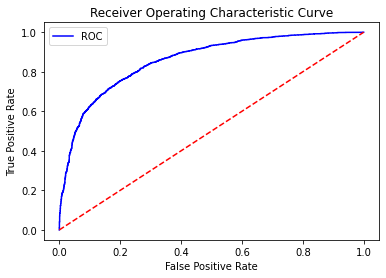

In [ ]:
# auroc
lgbm_noemb_auroc_score = roc_auc_score(ml_test_y, y_lgbm_noemb_pred, average=None)
print("AUROC : ", round(lgbm_noemb_auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = lgbm_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1]
fper, tper, thresholds = roc_curve(ml_test_y, prob)
plot_roc_curve(fper, tper)

AUPRC :  0.86


Text(0.5, 1.0, 'PRC(Precision Recall Curve)')

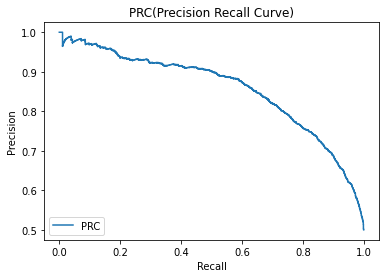

In [ ]:
# auprc
lgbm_noemb_auprc_score = average_precision_score(y_test, lgbm_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1], average=None)
print("AUPRC : ", round(lgbm_noemb_auprc_score,2))

# precision recall curve graph
_, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = precision_recall_curve(y_test, lgbm_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax, name='PRC')
ax.set_title('PRC(Precision Recall Curve)')

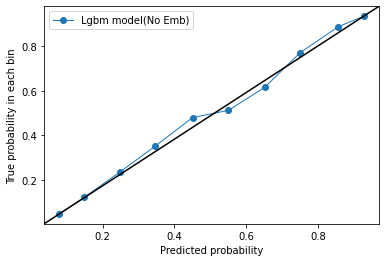

In [ ]:
# calibration curve
cal_y, cal_x = calibration_curve(y_test, lgbm_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1], n_bins=10)

_, ax = plt.subplots(figsize=(6, 4))
plt.plot(cal_x,cal_y,marker='o',linewidth=1,label='Lgbm model(No Emb)')
line = mlines.Line2D([0,1], [0,1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability in each bin")
plt.legend()
plt.show()

### XGBoost model(with embedding)

In [ ]:
 # Metrics for confusion matrix
y_xgb_pred = pd.DataFrame(xgb_model_emb.predict(ml_test), columns=['predict_first_outcome'])
y_xgb_pred[y_xgb_pred['predict_first_outcome']>=0.5] = 1
y_xgb_pred[y_xgb_pred['predict_first_outcome']<0.5] = 0
target_names = ['0','1']
print(classification_report(ml_test_y, y_xgb_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      2536
           1       0.82      0.78      0.80      2536

    accuracy                           0.80      5072
   macro avg       0.80      0.80      0.80      5072
weighted avg       0.80      0.80      0.80      5072



In [ ]:
# brier score loss(0~1 사이 범위를 가지며 0에 가까울수록 완벽한 분류모델
print("Brier score : ", brier_score_loss(y_test, xgb_model_emb.predict_proba(ml_test)[:,1]))

Brier score :  0.14011710873436845


AUROC :  0.8


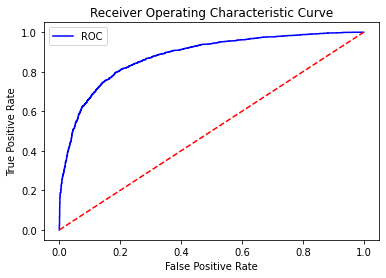

In [ ]:
# auroc
xgb_auroc_score = roc_auc_score(ml_test_y, y_xgb_pred, average=None)
print("AUROC : ", round(xgb_auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = xgb_model_emb.predict_proba(ml_test)[:,1]
fper, tper, thresholds = roc_curve(ml_test_y, prob)
plot_roc_curve(fper, tper)

AUPRC :  0.88


Text(0.5, 1.0, 'PRC(Precision Recall Curve)')

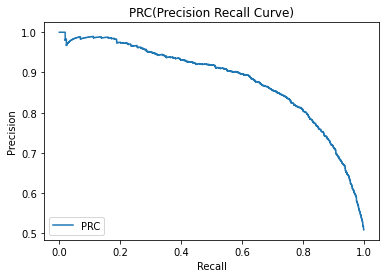

In [ ]:
# auprc
xgb_auprc_score = average_precision_score(y_test, xgb_model_emb.predict_proba(ml_test)[:,1], average=None)
print("AUPRC : ", round(xgb_auprc_score,2))

# precision recall curve graph
_, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = precision_recall_curve(y_test, xgb_model_emb.predict_proba(ml_test)[:,1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax, name='PRC')
ax.set_title('PRC(Precision Recall Curve)')

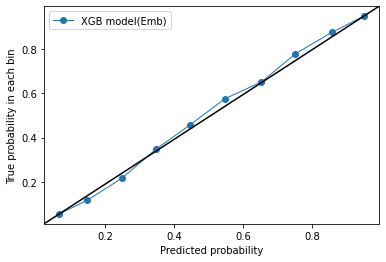

In [ ]:
# calibration curve
cal_y, cal_x = calibration_curve(y_test, xgb_model_emb.predict_proba(ml_test)[:,1], n_bins=10)

_, ax = plt.subplots(figsize=(6, 4))
plt.plot(cal_x,cal_y,marker='o',linewidth=1,label='XGB model(Emb)')
line = mlines.Line2D([0,1], [0,1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability in each bin")
plt.legend()
plt.show()

### XGBoost model(without embedding)

In [ ]:
 # Metrics for confusion matrix
y_xgb_noemb_pred = pd.DataFrame(xgb_model_no_emb.predict(ml_test.iloc[:,:29]), columns=['predict_first_outcome'])
y_xgb_noemb_pred[y_xgb_noemb_pred['predict_first_outcome']>=0.5] = 1
y_xgb_noemb_pred[y_xgb_noemb_pred['predict_first_outcome']<0.5] = 0
target_names = ['0','1']
print(classification_report(ml_test_y, y_xgb_noemb_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      2536
           1       0.79      0.76      0.77      2536

    accuracy                           0.78      5072
   macro avg       0.78      0.78      0.78      5072
weighted avg       0.78      0.78      0.78      5072



In [ ]:
# brier score loss(0~1 사이 범위를 가지며 0에 가까울수록 완벽한 분류모델
print("Brier score : ", brier_score_loss(y_test, xgb_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1]))

Brier score :  0.15474761503830897


AUROC :  0.78


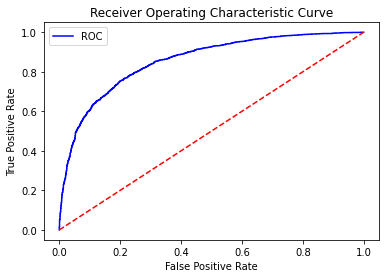

In [ ]:
# auroc
xgb_noemb_auroc_score = roc_auc_score(ml_test_y, y_xgb_noemb_pred, average=None)
print("AUROC : ", round(xgb_noemb_auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = xgb_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1]
fper, tper, thresholds = roc_curve(ml_test_y, prob)
plot_roc_curve(fper, tper)

AUPRC :  0.85


Text(0.5, 1.0, 'PRC(Precision Recall Curve)')

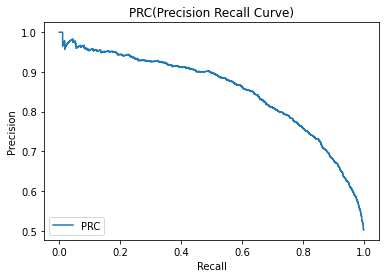

In [ ]:
# auprc
xgb_noemb_auprc_score = average_precision_score(y_test, xgb_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1], average=None)
print("AUPRC : ", round(xgb_noemb_auprc_score,2))

# precision recall curve graph
_, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = precision_recall_curve(y_test, xgb_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax, name='PRC')
ax.set_title('PRC(Precision Recall Curve)')

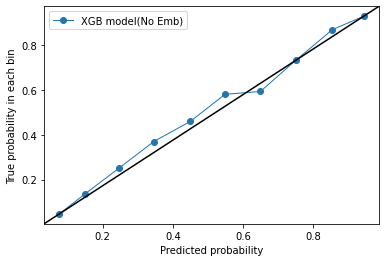

In [ ]:
# calibration curve
cal_y, cal_x = calibration_curve(y_test, xgb_model_no_emb.predict_proba(ml_test.iloc[:,:29])[:,1], n_bins=10)

_, ax = plt.subplots(figsize=(6, 4))
plt.plot(cal_x,cal_y,marker='o',linewidth=1,label='XGB model(No Emb)')
line = mlines.Line2D([0,1], [0,1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability in each bin")
plt.legend()
plt.show()